In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Functions to print the images
def myImPrt(img):
    tmp_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(tmp_img)

def myBWImPrt(img):
    plt.imshow(img,cmap='gray')

In [3]:
# ref #https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
def bilateralFilter(image, d, sig):
    image = cv2.bilateralFilter(image, d, sig, sig)
    return image

def threshold(image, t):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, image = cv2.threshold(image, t, 255, cv2.THRESH_BINARY_INV)
#     ret, image = cv2.threshold(image, t, 255, cv2.THRESH_BINARY)
    return image

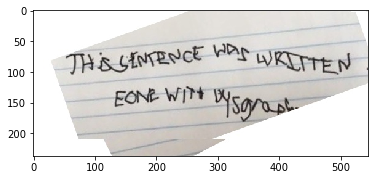

In [4]:
image = cv2.imread('images/straightened.jpg')
# cv2.imshow('image',image)
myImPrt(image)

In [5]:
TOP_MARGIN = 0.0
LETTER_SIZE = 0.00001
LINE_SPACING = 0.0
WORD_SPACING = 0.0


In [6]:
#function to calculate horizontal projection of the image pixel rows and return it 
def horizontalProjection(img):
    # Return a list containing the sum of the pixels in each row
    (h, w) = img.shape[:2]
    sumRows = []
    for j in range(h):
        row = img[j:j+1, 0:w] # y1:y2, x1:x2
        sumRows.append(np.sum(row))
    return sumRows

In [7]:
# function to calculate vertical projection of the image pixel columns and return it
def verticalProjection(img):
    # Return a list containing the sum of the pixels in each column
    (h, w) = img.shape[:2]
    sumCols = []
    for j in range(w):
        col = img[0:h, j:j+1] # y1:y2, x1:x2
        sumCols.append(np.sum(col))
    return sumCols

In [8]:
img = image.copy()

In [9]:
filtered = bilateralFilter(img, 5, 50) 

thresh = threshold(filtered, 127)

# extract a python list containing values of the horizontal projection of the image into 'hp'
hpList = horizontalProjection(thresh)

# Extracting 'Top Margin' feature.
topMarginCount = 0
for sum in hpList:
    # sum can be strictly 0 as well.
    if(sum<=255):
        topMarginCount += 1
    else:
        break


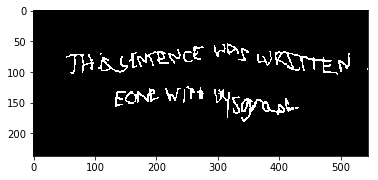

In [10]:
plt.imshow(thresh,cmap='gray')

In [11]:
lineTop = 0
lineBottom = 0
spaceTop = 0
spaceBottom = 0
setLineTop = True
setSpaceTop = True
includeNextSpace = True
space_zero = [] # stores the amount of space between lines
lines = [] # a 2D list storing the vertical start index and end index of each contour

In [12]:
# FIRST we extract the straightened contours from the image by looking at occurance of 0's in the horizontal projection.
# we are scanning the whole horizontal projection now 
for i, sum in enumerate(hpList):
    # sum being 0 means blank space
    if(sum<3000):
        if(setSpaceTop):
            spaceTop = i;
            setSpaceTop = False # spaceTop will be set once for each start of a space between lines
        spaceBottom = i+1;
       
        if(i<len(hpList)-1): # this condition is necessary to avoid array index out of bound error
            if(hpList[i+1]<3000): # if the next horizontal projectin is 0, keep on counting, it's still in blank space
                continue
        # we are using this condition if the previous contour is very thin and possibly not a line
        if(includeNextSpace):
            space_zero.append(spaceBottom-spaceTop)
        else:
            if (len(space_zero)==0):
                previous = 0
            else:
                previous = space_zero.pop()
            space_zero.append(previous + spaceBottom-lineTop)
        setSpaceTop = True # next time we encounter 0, it's begining of another space so we set new spaceTop

    # sum greater than 0 means contour
    if(sum>3000):
        if(setLineTop):
            lineTop = i
            setLineTop = False # lineTop will be set once for each start of a new line/contour
        lineBottom = i+1

        if(i<len(hpList)-1): # this condition is necessary to avoid array index out of bound error
            if(hpList[i+1]>3000): # if the next horizontal projectin is > 0, keep on counting, it's still in contour
                continue

            # if the line/contour is too thin <10 pixels (arbitrary) in height, we ignore it.
            # Also, we add the space following this and this contour itself to the previous space to form a bigger space: spaceBottom-lineTop.
            if(lineBottom-lineTop<20):
                includeNextSpace = False
                setLineTop = True # next time we encounter value > 0, it's begining of another line/contour so we set new lineTop
                continue
        includeNextSpace = True # the line/contour is accepted, new space following it will be accepted

        # append the top and bottom horizontal indices of the line/contour in 'lines'
        lines.append([lineTop, lineBottom])
        setLineTop = True # next time we encounter value > 0, it's begining of another line/contour so we set new lineTop


In [13]:

# Printing the values we found so far.
for i, line in enumerate(lines):
    print()
    print (i)
    print (line[0])
    print (line[1])
    print (len(hpList[line[0]:line[1]]))
    print (hpList[line[0]:line[1]])




0
57
103
46
[3825, 3825, 5355, 8160, 8925, 7395, 6630, 7395, 10200, 11985, 18105, 24480, 26520, 23205, 26775, 27540, 23970, 23460, 24735, 22950, 25500, 29580, 32640, 35955, 34170, 33915, 28560, 24990, 24735, 23205, 21930, 18615, 20400, 19890, 19635, 15810, 16065, 13770, 13515, 13260, 13515, 12495, 8925, 8925, 8415, 4080]

1
126
169
43
[3315, 5355, 6885, 8925, 9690, 12750, 16575, 18615, 16320, 17085, 15300, 15555, 16320, 16065, 14535, 17850, 18870, 21420, 22185, 19635, 18105, 16320, 17850, 17595, 15045, 12750, 11475, 13005, 13005, 11475, 10455, 11475, 13515, 14535, 13005, 12750, 12495, 14790, 13515, 10710, 6885, 5610, 3570]


In [14]:
# for i, line in enumerate(lines):
#     cv2.imshow("line "+str(i), img[line[0]:line[1], : ])
# cv2.waitKey(0)

In [15]:
# LINE SPACING and LETTER SIZE will be extracted here
# We will count the total number of pixel rows containing upper and lower zones of the lines 
# and add the space_zero/runs of 0's(excluding first and last of the list ) to it.
# We will count the total number of pixel rows containing midzones of the lines for letter size.
# For this, we set an arbitrary (yet suitable!) threshold THRESHOLD = 15000 in 
# horizontal projection to identify the midzone containing rows.
# These two total numbers will be divided by number of lines (having at least one row>THRESHOLD) 
# to find average line spacing and average letter size.
THRESHOLD = 15000
new_space_row_count = 0
total_row_count = 0
total_lines_count = 0
flag = False
for i, line in enumerate(lines):
    segment = hpList[line[0]:line[1]]
    for j, sum in enumerate(segment):
        if(sum<THRESHOLD):
            new_space_row_count += 1
        else:
            total_row_count += 1
            flag = True

    # This line has contributed at least one count of pixel row of midzone
    if(flag):
        total_lines_count += 1
        flag = False

In [16]:
# error prevention
if(total_lines_count == 0): total_lines_count = 1

total_space_row_count = new_space_row_count + np.sum(space_zero[1:-1]) #excluding first and last entries: Top and Bottom margins
# the number of spaces is 1 less than number of lines but total_space_row_count contains the top and bottom spaces of the line
average_line_spacing = float(total_space_row_count) / total_lines_count 
average_letter_size = float(total_row_count) / total_lines_count
# letter size is actually height of the letter and we are not considering width
LETTER_SIZE = average_letter_size
# error prevention 
if(average_letter_size == 0): average_letter_size = 1
# We can't just take the average_line_spacing as a feature directly. We must take the average_line_spacing relative to average_letter_size.
# Let's take the ratio of average_line_spacing to average_letter_size as the LINE SPACING, which is perspective to average_letter_size.
relative_line_spacing = average_line_spacing / average_letter_size
LINE_SPACING = relative_line_spacing

# Top marging is also taken relative to average letter size of the handwritting
# relative_top_margin = float(topMarginCount) / average_letter_size
# TOP_MARGIN = relative_top_margin


In [17]:
print(space_zero)
print(lines)
print(total_row_count)
print(total_space_row_count)
print(len(hpList))
print(total_lines_count)
print(i)
print("Average Line Spacing: "+ str(average_line_spacing))
print ("Average letter size: "+ str(average_letter_size))
# print ("Top margin relative to average letter size: "+str(relative_top_margin))
print("Average line spacing relative to \naverage letter size: "+str(relative_line_spacing)) 


[57, 23, 68]
[[57, 103], [126, 169]]
45
67
237
2
1
Average Line Spacing: 33.5
Average letter size: 22.5
Average line spacing relative to 
average letter size: 1.488888888888889


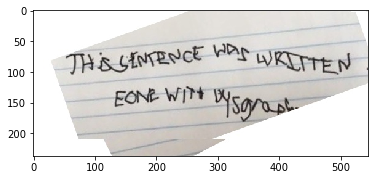

In [18]:
myImPrt(image)

In [19]:
# Extraction of words from the lines using vertical projection
# Width of the whole document is found once.
width = thresh.shape[1]
space_zero = [] # stores the amount of space between words
words = [] # a 2D list storing the coordinates of each word: y1, y2, x1, x2

In [20]:
# Isolated words or components will be extacted from each line by looking at occurance of 0's in its vertical projection.
for i, line in enumerate(lines):
    extract = thresh[line[0]:line[1], 0:width] # y1:y2, x1:x2
    vp = verticalProjection(extract)
    wordStart = 0
    wordEnd = 0
    spaceStart = 0
    spaceEnd = 0
    setWordStart = True
    setSpaceStart = True
    includeNextSpace = False
    
#     spaces = []

    # we are scanning the vertical projection
    for j, sum in enumerate(vp):
        # sum being 0 means blank space
        if(sum==0):
            if(setSpaceStart):
                spaceStart = j
                setSpaceStart = False # spaceStart will be set once for each start of a space between lines
            spaceEnd = j+1
            if(j<len(vp)-1): # this condition is necessary to avoid array index out of bound error
                if(vp[j+1]==0): # if the next vertical projectin is 0, keep on counting, it's still in blank space
                    continue

            # we ignore spaces which is smaller than half the average letter size
            if((spaceEnd-spaceStart) > int(LETTER_SIZE/2)):
                space_zero.append(spaceEnd-spaceStart)
            else:
                includeNextSpace=True  
                
            setSpaceStart = True # next time we encounter 0, it's begining of another space so we set new spaceStart

        # sum greater than 0 means word
        if(sum>0):
            if(setWordStart):
                wordStart = j
                setWordStart = False # wordStart will be set once for each start of a new word/component
            wordEnd = j+1
            if(j<len(vp)-1): # this condition is necessary to avoid array index out of bound error
                if(vp[j+1]>0): # if the next horizontal projectin is > 0, keep on counting, it's still in non-space zone
                    continue

            # append the coordinates of each word/component: y1, y2, x1, x2 in 'words'
            # we ignore the ones which has height smaller than half the average letter size
            # this will remove full stops and commas as an individual component
            count = 0
            for k in range(line[1]-line[0]):
                row = thresh[line[0]+k:line[0]+k+1, wordStart:wordEnd] # y1:y2, x1:x2
                if(np.sum(row)):
                    count += 1
                #U.S.A. special case not handelled
            if(count > int(LETTER_SIZE/2)):
                if(includeNextSpace):
                    includeNextSpace = False
                    if(len(words)!=0):
                        words[len(words)-1][3] = wordEnd
                else:
                    words.append([line[0], line[1], wordStart, wordEnd])

            setWordStart = True # next time we encounter value > 0, it's begining of another word/component so we set new wordStart

#     space_zero.extend(spaces[1:-1])


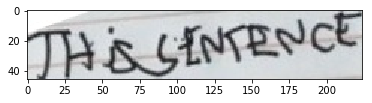

In [21]:
# cv2.imshow("word "+str(i), thresh[words[0][0]:words[0][1], words[0][2]:words[0][3]])
# print("Words count is: ")
# print(len(words))
word = words[0]
myBWImPrt(image[word[0]:word[1], word[2]:word[3]])
# myBWImPrt(thresh)


In [22]:
# for i, word in enumerate(words):
#     cv2.imshow("word "+str(i), image[word[0]:word[1], word[2]:word[3]])
# cv2.waitKey(0)

In [23]:
#print space_zero
space_columns = np.sum(space_zero)
space_count = len(space_zero)
if(space_count == 0):
    space_count = 1
average_word_spacing = float(space_columns) / space_count
relative_word_spacing = average_word_spacing / LETTER_SIZE
WORD_SPACING = relative_word_spacing
#print "Average word spacing: "+str(average_word_spacing)
print ("Average word spacing relative to average letter size: "+str(relative_word_spacing))

Average word spacing relative to average letter size: 2.361904761904762
